<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/PYSR_new_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install nodepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.2/823.2 kB 11.2 MB/s eta 0:00:00


In [4]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [22]:
"""
@author: Maziar Raissi
"""

import numpy as np
# import tensorflow as tf
import nodepy.linear_multistep_method as lm
import timeit

np.random.seed(134)
tf.compat.v1.set_random_seed(123)

class Multistep_NN:
    def __init__(self, dt, X, layers, M, scheme):

        self.dt = dt
        self.X = X # S x N x D

        self.S = X.shape[0] # number of trajectories
        self.N = X.shape[1] # number of time snapshots
        self.D = X.shape[2] # number of dimensions

        self.M = M # number of Adams-Moulton steps

        self.layers = layers

        "defining alpha and Beta based on selected method"
        # Load weights
        switch = {'AM': lm.Adams_Moulton,
                  'AB': lm.Adams_Bashforth,
                  'BDF': lm.backward_difference_formula}
        method = switch[scheme](M)
        self.alpha = np.float32(-method.alpha[::-1])
        self.beta = np.float32(method.beta[::-1])

        '''self.X_tf: A placeholder for input data, representing the state of the system at different time instances.
        It is a tensor with dimensions [self.S, None, self.D], where S is the number of trajectories, None allows for
        variable number of time snapshots, and D is the number of dimensions (state variables).
        self.X_star_tf: A placeholder for the points at which the neural network will make predictions.
        It has dimensions [None, self.D], where None allows for a variable number of prediction points.'''
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        self.X_tf = tf.placeholder(tf.float32, shape=[self.S, None, self.D]) # S x N x D
        self.X_star_tf = tf.placeholder(tf.float32, shape=[None, self.D]) # N_star x D

        '''tf.variable_scope along with a randomly generated scope name is a technique to
        ensure the creation of unique namespaces for TensorFlow variables.'''

        scope_name = str(np.random.randint(1e6))
        with tf.variable_scope(scope_name) as scope:
            self.f_pred = self.neural_net(self.X_star_tf) # N_star x D
        with tf.variable_scope(scope, reuse=True):
            self.Y_pred = self.net_Y(self.X_tf) # S x N x D

        #loss function, D= N-M+1
        self.loss = self.D*tf.reduce_mean(tf.square(self.Y_pred))

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

    def neural_net(self, H):
        num_layers = len(self.layers)
        for l in range(0,num_layers-2):
            with tf.variable_scope("layer%d" %(l+1)):
                H = tf.layers.dense(inputs=H, units=self.layers[l+1], activation=tf.nn.tanh)
        with tf.variable_scope("layer%d" %(num_layers-1)):
            H = tf.layers.dense(inputs=H, units=self.layers[-1], activation=None)
        return H

    def net_F(self, X): # S x (N-M+1) x D
        X_reshaped = tf.reshape(X, [-1,self.D]) # S(N-M+1) x D
        F_reshaped = self.neural_net(X_reshaped) # S(N-M+1) x D
        F = tf.reshape(F_reshaped, [self.S,-1,self.D]) # S x (N-M+1) x D
        return F # S x (N-M+1) x D

    def net_Y(self, X): # S x N x D
        M = self.M

        Y = self.alpha[0]*X[:,M:,:] + self.dt*self.beta[0]*self.net_F(X[:,M:,:])
        for m in range(1, M+1):
            Y = Y + self.alpha[m]*X[:,M-m:-m,:] + self.dt*self.beta[m]*self.net_F(X[:,M-m:-m,:]) # S x (N-M+1) x D

        return Y # S x (N-M+1) x D

    def train(self, N_Iter):

        tf_dict = {self.X_tf: self.X}

        start_time = timeit.default_timer()
        for it in range(N_Iter):

            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if it % 1000 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = timeit.default_timer()


    def predict_f(self, X_star):

        F_star = self.sess.run(self.f_pred, {self.X_star_tf: X_star})

        return F_star

#**glyco**

In [23]:
"""
@author: Maziar Raissi
"""
# np.random.seed(1234)
# tf.compat.v1.set_random_seed(1234)
# from Multistep_NN import Multistep_NN

# import numpy as np
# from scipy.integrate import odeint

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# from plotting import newfig, savefig
# import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
if __name__ == "__main__":

    # function that returns dx/dt
    def f(x,t): # x is 3 x 1
        J0 = 2.5
        k1 = 100.0
        k2 = 6.0
        k3 = 16.0
        k4 = 100.0
        k5 = 1.28
        k6 = 12.0
        k = 1.8
        kappa = 13.0
        q = 4
        K1 = 0.52
        psi = 0.1
        N = 1.0
        A = 4.0

        f1 = J0 - (k1*x[0]*x[5])/(1 + (x[5]/K1)**q)
        f2 = 2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) - k2*x[1]*(N-x[4]) - k6*x[1]*x[4]
        f3 = k2*x[1]*(N-x[4]) - k3*x[2]*(A-x[5])
        f4 = k3*x[2]*(A-x[5]) - k4*x[3]*x[4] - kappa*(x[3]-x[6])
        f5 = k2*x[1]*(N-x[4]) - k4*x[3]*x[4] - k6*x[1]*x[4]
        f6 = -2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) + 2*k3*x[2]*(A-x[5]) - k5*x[5]
        f7 = psi*kappa*(x[3]-x[6]) - k*x[6]

        f = np.array([f1,f2,f3,f4,f5,f6,f7])
        return f

    # time points
    t_star = np.arange(0,10,0.01)

    # S1 = np.random.uniform(0.15,1.60,1)
    # S2 = np.random.uniform(0.19,2.16,1)
    # S3 = np.random.uniform(0.04,0.20,1)
    # S4 = np.random.uniform(0.10,0.35,1)
    # S5 = np.random.uniform(0.08,0.30,1)
    # S6 = np.random.uniform(0.14,2.67,1)
    # S7 = np.random.uniform(0.05,0.10,1)

    S1 = 1.1
    S2 = 1.0
    S3 = 0.075
    S4 = 0.18
    S5 = 0.28
    S6 = 0.75
    S7 = 0.09

    # initial condition
    x0 = np.array([S1,S2,S3,S4,S5,S6,S7]).flatten()

    # solve ODE
    X_star = odeint(f, x0, t_star)

    noise = 0.00

    skip = 1
    dt = t_star[skip] - t_star[0]
    X_train = X_star[0::skip,:]
    X_train = X_train + noise*X_train.std(0)*np.random.randn(X_train.shape[0], X_train.shape[1])

    X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))

    layers = [7, 256, 7]

    M = 1
    scheme = 'AM'
    model = Multistep_NN(dt, X_train, layers, M, scheme)

    N_Iter = 50000
    model.train(N_Iter)
    learned_f_outputs = []
    def learned_f(x,t):
        f = model.predict_f(x[None,:])
        return f.flatten()

    learned_X_star = odeint(learned_f, x0, t_star)


    t_star_reshaped = t_star.reshape(-1, 1)



Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



<ipython-input-22-bd00250c02ce>:69: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  H = tf.layers.dense(inputs=H, units=self.layers[l+1], activation=tf.nn.tanh)
<ipython-input-22-bd00250c02ce>:71: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  H = tf.layers.dense(inputs=H, units=self.layers[-1], activation=None)


It: 0, Loss: 8.363e-03, Time: 0.15
It: 1000, Loss: 8.703e-04, Time: 1.05
It: 2000, Loss: 3.784e-04, Time: 1.01
It: 3000, Loss: 1.730e-04, Time: 0.98
It: 4000, Loss: 6.727e-05, Time: 1.02
It: 5000, Loss: 4.375e-05, Time: 1.04
It: 6000, Loss: 3.837e-05, Time: 1.06
It: 7000, Loss: 3.556e-05, Time: 0.99
It: 8000, Loss: 3.349e-05, Time: 1.00
It: 9000, Loss: 3.173e-05, Time: 0.96
It: 10000, Loss: 3.019e-05, Time: 0.97
It: 11000, Loss: 2.888e-05, Time: 0.97
It: 12000, Loss: 2.771e-05, Time: 1.00
It: 13000, Loss: 2.669e-05, Time: 0.99
It: 14000, Loss: 2.581e-05, Time: 1.00
It: 15000, Loss: 2.510e-05, Time: 0.99
It: 16000, Loss: 2.445e-05, Time: 0.97
It: 17000, Loss: 2.392e-05, Time: 1.04
It: 18000, Loss: 2.348e-05, Time: 1.04
It: 19000, Loss: 2.312e-05, Time: 1.03
It: 20000, Loss: 2.280e-05, Time: 0.98
It: 21000, Loss: 2.251e-05, Time: 1.00
It: 22000, Loss: 2.225e-05, Time: 0.99
It: 23000, Loss: 2.202e-05, Time: 0.99
It: 24000, Loss: 2.187e-05, Time: 0.98
It: 25000, Loss: 2.161e-05, Time: 0.99

<ipython-input-25-804651e4eb46>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[0:1, 0:1])


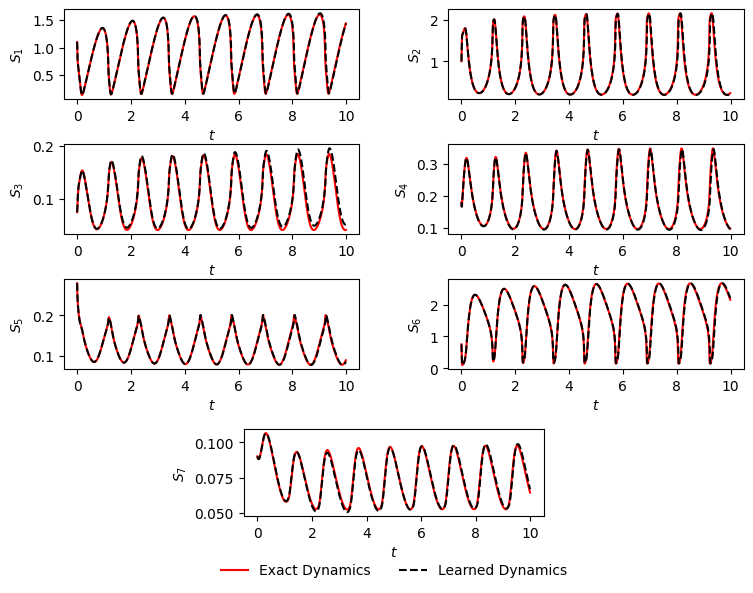

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')

gs0 = gridspec.GridSpec(3, 2)
gs0.update(top=0.95, bottom=0.35, left=0.1, right=0.95, hspace=0.5, wspace=0.3)

ax = plt.subplot(gs0[0:1, 0:1])
ax.plot(t_star,X_star[:,0],'r-')
ax.plot(t_star,learned_X_star[:,0],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_1$')

ax = plt.subplot(gs0[0:1, 1:2])
ax.plot(t_star,X_star[:,1],'r-')
ax.plot(t_star,learned_X_star[:,1],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_2$')

ax = plt.subplot(gs0[1:2, 0:1])
ax.plot(t_star,X_star[:,2],'r-')
ax.plot(t_star,learned_X_star[:,2],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_3$')

ax = plt.subplot(gs0[1:2, 1:2])
ax.plot(t_star,X_star[:,3],'r-')
ax.plot(t_star,learned_X_star[:,3],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_4$')

ax = plt.subplot(gs0[2:3, 0:1])
ax.plot(t_star,X_star[:,4],'r-')
ax.plot(t_star,learned_X_star[:,4],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_5$')

ax = plt.subplot(gs0[2:3, 1:2])
ax.plot(t_star,X_star[:,5],'r-')
ax.plot(t_star,learned_X_star[:,5],'k--')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_6$')

gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.25, bottom=0.105, left=0.325, right=0.7, hspace=0.5, wspace=0.3)

ax = plt.subplot(gs1[0:1, 0:2])
ax.plot(t_star,X_star[:,6],'r-',label='Exact Dynamics')
ax.plot(t_star,learned_X_star[:,6],'k--',label='Learned Dynamics')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_7$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2, frameon=False)

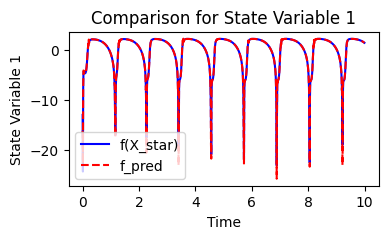

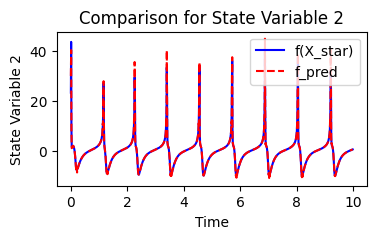

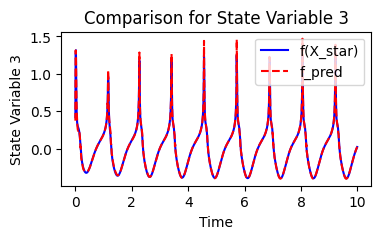

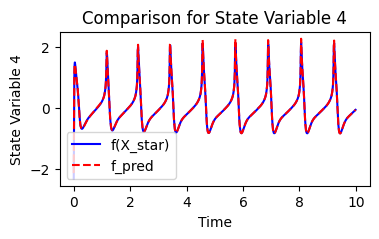

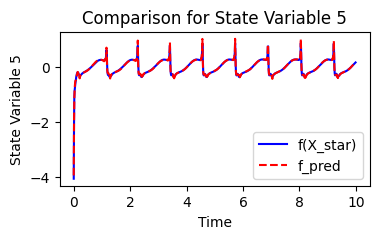

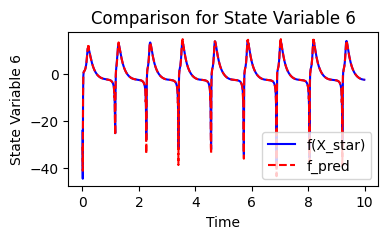

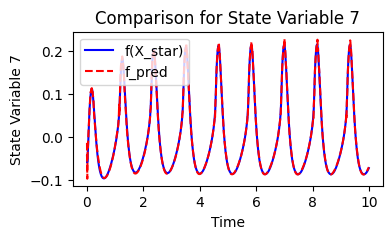

In [26]:
import numpy as np
import matplotlib.pyplot as plt


f_pred = model.sess.run(model.f_pred, feed_dict={model.X_star_tf: X_star})
# Assuming the function f and arrays X_star and f_pred are already defined
# f_pred should be the prediction from your system, and X_star should be your input data
def f(x):
    # Constants
    J0 = 2.5
    k1 = 100.0
    k2 = 6.0
    k3 = 16.0
    k4 = 100.0
    k5 = 1.28
    k6 = 12.0
    k = 1.8
    kappa = 13.0
    q = 4
    K1 = 0.52
    psi = 0.1
    N = 1.0
    A = 4.0

    # Derivative calculations
    f1 = J0 - (k1*x[0]*x[5])/(1 + (x[5]/K1)**q)
    f2 = 2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) - k2*x[1]*(N-x[4]) - k6*x[1]*x[4]
    f3 = k2*x[1]*(N-x[4]) - k3*x[2]*(A-x[5])
    f4 = k3*x[2]*(A-x[5]) - k4*x[3]*x[4] - kappa*(x[3]-x[6])
    f5 = k2*x[1]*(N-x[4]) - k4*x[3]*x[4] - k6*x[1]*x[4]
    f6 = -2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) + 2*k3*x[2]*(A-x[5]) - k5*x[5]
    f7 = psi*kappa*(x[3]-x[6]) - k*x[6]

    # Return the derivatives as an array
    return np.array([f1, f2, f3, f4, f5, f6, f7])
# Evaluate f on each row of X_star
f_x_star = np.array([f(x) for x in X_star])

# Check if the dimensions match
if f_x_star.shape != f_pred.shape:
    raise ValueError("The shapes of f_x_star and f_pred must be the same.")

# Number of state variables (assuming f_x_star and f_pred have the same second dimension)
num_states = f_x_star.shape[1]

# Plotting each state variable
for i in range(num_states):
    plt.figure(figsize=(4, 2))
    plt.plot(t_star, f_x_star[:, i], label='f(X_star)', color='blue', linestyle='-')
    plt.plot(t_star, f_pred[:, i], label='f_pred', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'State Variable {i+1}')
    plt.title(f'Comparison for State Variable {i+1}')
    plt.legend()
    plt.show()


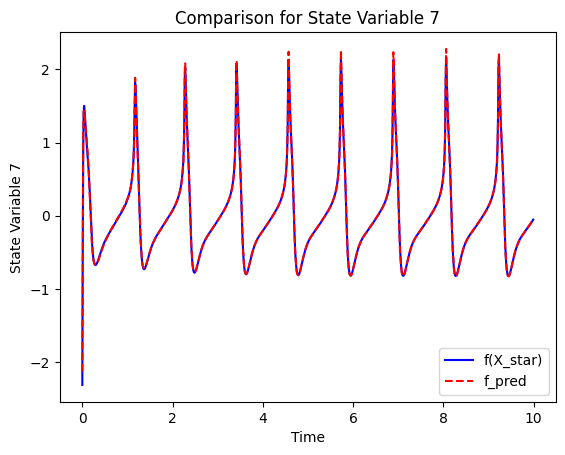

In [27]:
plt.plot(t_star, f_x_star[:, 3], label='f(X_star)', color='blue', linestyle='-')
plt.plot(t_star, f_pred[:, 3], label='f_pred', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel(f'State Variable {i+1}')
plt.title(f'Comparison for State Variable {i+1}')
plt.legend()
plt.show()

In [49]:
!pip install pandas
import pandas as pd

# Assuming t_star, f_pred, X_star, and f_x_star are already defined

# Check if the lengths of t_star, f_pred, and X_star match
if len(t_star) != f_pred.shape[0] or len(t_star) != X_star.shape[0] or len(t_star) != f_x_star.shape[0]:
    raise ValueError("The lengths of t_star, f_pred, X_star, and f_x_star must all be the same.")

# Number of state variables (assuming all arrays have the same second dimension)
num_states = f_pred.shape[1]

# Prepare data for DataFrame
data = {"t_star": t_star}
for i in range(num_states):
    data[f'f_pred_{i+1}'] = f_pred[:, i]

for i in range(num_states):
    data[f'X{i+1}'] = X_star[:, i]

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('bio_data.csv', index=False)

# Informing that the file has been saved
print("Data saved to 'combined_data.csv'.")


Data saved to 'combined_data.csv'.


#**SR**

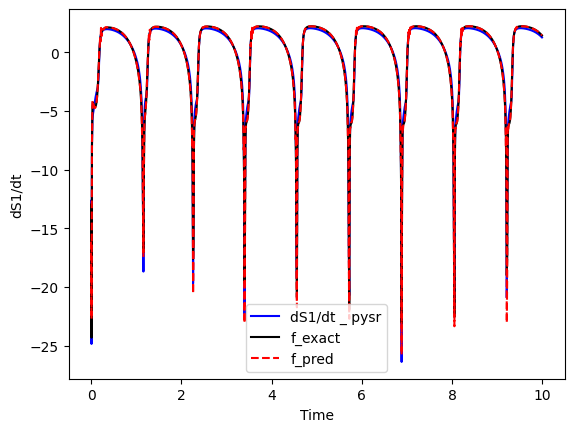

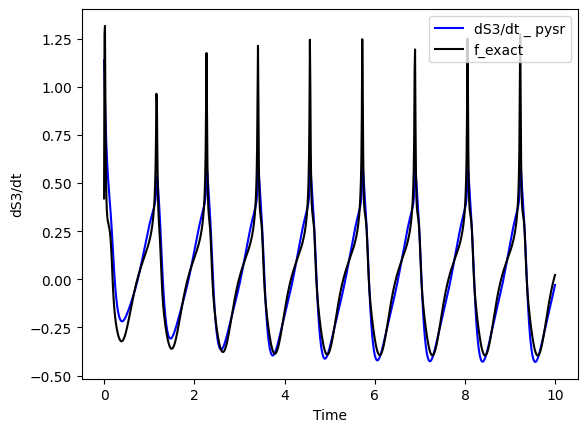

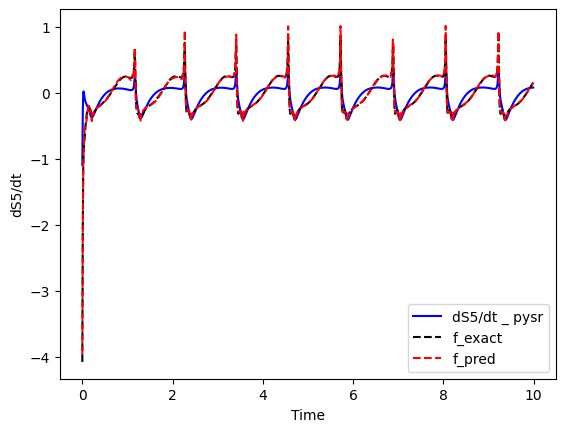

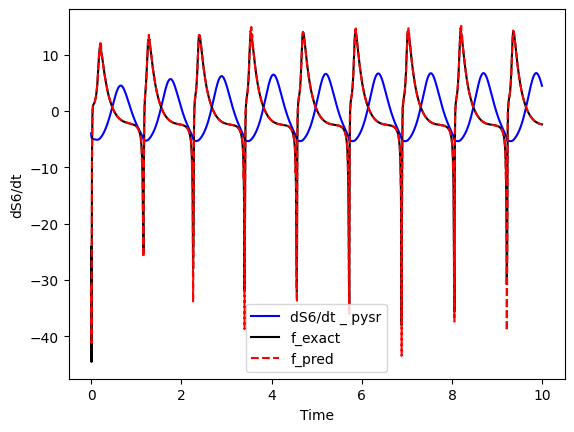

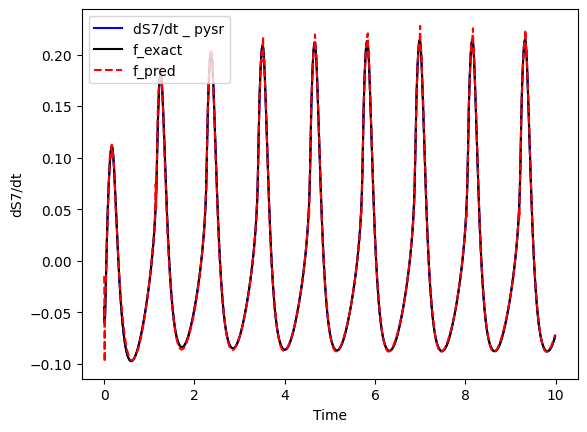

In [56]:
J0 = 2.5
k1 = 100.0
k2 = 6.0
k3 = 16.0
k4 = 100.0
k5 = 1.28
k6 = 12.0
k = 1.8
kappa = 13.0
q = 4
K1 = 0.52
psi = 0.1
N = 1.0
A = 4.0

# # Derivative calculations
f1 = J0 - (k1*X_star[:,0]*X_star[:,5])/(1 + (X_star[:,5]/K1)**q)
f2 = 2*(k1*X_star[:,0]*X_star[:,5])/(1 + (X_star[:,5]/K1)**q) - k2*X_star[:,1]*(N-X_star[:,4]) - k6*X_star[:,1]*X_star[:,4]
f3 = k2*X_star[:,1]*(N-X_star[:,4]) - k3*X_star[:,2]*(A-X_star[:,5])
f4 = k3*X_star[:,2]*(A-X_star[:,5]) - k4*X_star[:,3]*X_star[:,4] - kappa*(X_star[:,3]-X_star[:,6])
f5 = k2*X_star[:,1]*(N-X_star[:,4]) - k4*X_star[:,3]*X_star[:,4] - k6*X_star[:,1]*X_star[:,4]
f6 = -2*(k1*X_star[:,0]*X_star[:,5])/(1 + (X_star[:,5]/K1)**q) + 2*k3*X_star[:,2]*(A-X_star[:,5]) - k5*X_star[:,5]
f7 = psi*kappa*(X_star[:,3]-X_star[:,6]) - k*X_star[:,6]

####pysr results#############
f1_pysr= X_star[:,0]/(-0.383253963933312*X_star[:,5]**2 + 0.33681357*X_star[:,5] - 0.105263213338505) + 2.6049361
# f3_pysr= - 2.35* X_star[:,1] - 0.401 * X_star[:,1] + 0.922
f3_pysr=  0.146 *X_star[:,1] - 5.37 *X_star[:,2] + 5.37 *X_star[:,4] - 0.146 *X_star[:,5]
# f3_pysr= - 0.312* X_star[:,2] - 0.515*X_star[:,5] + 1.13
f5_pysr = X_star[:,1] - 56.2*X_star[:,3]* X_star[:,4] + 2.54* X_star[:,3] + X_star[:,4]
f6_pysr= -6.5423465 + (X_star[:,6] + 2.4707518)/X_star[:,1]
###########################
f1_pysr = -X_star[:,0]/(0.4525158*(X_star[:,5] - 0.8335079)*(X_star[:,5] - 0.06080126) + 0.09931651) + 2.3530831
############################
#dS7/dt= 1.3000822*x0 - 3.0997634*x1
#dS7/dt= 1.30 x_{0} - 3.10 x_{1}
f7_pysr= 1.30 * X_star[:,3] - 3.09976 * X_star[:,6]
############################
plt.figure()
plt.plot(t_star, f1_pysr, label='dS1/dt _ pysr', color='blue', linestyle='-')
plt.plot(t_star, f1,'k', label='f_exact')
plt.plot(t_star, f_pred[:, 0],'--r', label='f_pred')
plt.xlabel('Time')
plt.ylabel(f'dS1/dt')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(t_star, f2_pysr, label='dS2/dt _ pysr', color='blue', linestyle='-')
# plt.plot(t_star, f2,'k', label='f_exact')
# plt.plot(t_star, f_pred[:, 1],'--r', label='f_pred')
# plt.xlabel('Time')
# plt.ylabel(f'dS2/dt')
# plt.legend()
# plt.show()

plt.figure()
plt.plot(t_star, f3_pysr, label='dS3/dt _ pysr', color='blue', linestyle='-')
plt.plot(t_star, f3,'k', label='f_exact')
# plt.plot(t_star, f_pred[:, 2],'--r', label='f_pred')
plt.xlabel('Time')
plt.ylabel(f'dS3/dt')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(t_star, f4_pysr, label='dS4/dt _ pysr', color='blue', linestyle='-')
# plt.plot(t_star, f4,'k', label='f_exact')
# plt.plot(t_star, f_pred[:, 3],'--r', label='f_pred')
# plt.xlabel('Time')
# plt.ylabel(f'dS4/dt')
# plt.legend()
# plt.show()

plt.figure()
plt.plot(t_star, f5_pysr, label='dS5/dt _ pysr', color='blue', linestyle='-')
plt.plot(t_star, f5,'--k', label='f_exact')
plt.plot(t_star, f_pred[:, 4],'--r', label='f_pred')
plt.xlabel('Time')
plt.ylabel(f'dS5/dt')
plt.legend()
plt.show()

plt.figure()
plt.plot(t_star, f6_pysr, label='dS6/dt _ pysr', color='blue', linestyle='-')
plt.plot(t_star, f6,'k', label='f_exact')
plt.plot(t_star, f_pred[:, 5],'--r', label='f_pred')
plt.xlabel('Time')
plt.ylabel(f'dS6/dt')
plt.legend()
plt.show()

plt.figure()
plt.plot(t_star, f7_pysr, label='dS7/dt _ pysr', color='blue', linestyle='-')
plt.plot(t_star, f7,'k', label='f_exact')
plt.plot(t_star, f_pred[:, 6],'--r', label='f_pred')
plt.xlabel('Time')
plt.ylabel(f'dS7/dt')
plt.legend()
plt.show()


# plt.xlabel('Time')
# plt.ylabel(f'State Variable {i+1}')
# plt.title(f'Comparison for State Variable {i+1}')
# plt.legend()
# plt.show()

In [54]:
import numpy as np
import pandas as pd

def compute_errors(true_values, predicted_values):
    # Compute Mean Absolute Error (MAE)
    mae = np.abs(true_values - predicted_values).mean()

    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(((true_values - predicted_values) ** 2).mean())

    # Compute Relative Error (RE)
    numerator = np.sqrt(np.sum((true_values - predicted_values) ** 2))
    denominator = np.sqrt(np.sum(predicted_values ** 2))
    re = numerator / denominator

    return mae, rmse, re

# Extract the true values and predicted values from the CSV data

# Calculate L1, L2, L∞, and L2 relative errors

print("_____________10 data points______________")
# Extract the true values and predicted values from the CSV data
pred_values = X_star[:,0]/(-0.383253963933312*X_star[:,5]**2 + 0.33681357*X_star[:,5] - 0.105263213338505) + 2.6049361
true_values = J0 - (k1*X_star[:,0]*X_star[:,5])/(1 + (X_star[:,5]/K1)**q)

########################################################
pred_values = 5.99*X_star[:,1]  - 18*X_star[:,1]*X_star[:,4]
true_values = k2*X_star[:,1]*(N-X_star[:,4])  - k6*X_star[:,1]*X_star[:,4]
########################################################
mae, rmse, re  = compute_errors(true_values, pred_values)
print(f"(MAE): {mae:.2e}")
print(f"(RMSE): {rmse:.2e}")
print(f"(RE): {re:.2e}")



_____________10 data points______________
(MAE): 7.24e-03
(RMSE): 9.44e-03
(RE): 3.38e-03


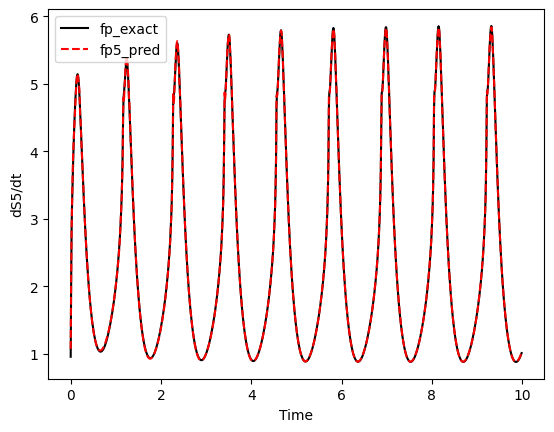

In [50]:



fp5_pred = f_pred[:, 4] + k4*X_star[:,3]*X_star[:,4]
fp_exact= k2*X_star[:,1]*(N-X_star[:,4])  - k6*X_star[:,1]*X_star[:,4]

data = {
    "t_star": t_star,
    "yp5": fp5_pred,
    "X2": X_star[:, 1],  # Assuming X_star[:, 1] is the second column of interest
    "X5": X_star[:, 4],  # Assuming X_star[:, 4] is the fifth column of interest
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_filename = 'fp5_data.csv'
df.to_csv(csv_filename, index=False)

plt.figure()
# plt.plot(t_star, f7_pysr, label='dS7/dt _ pysr', color='blue', linestyle='-')
plt.plot(t_star, fp_exact,'k', label='fp_exact')
plt.plot(t_star, fp5_pred,'--r', label='fp5_pred')
plt.xlabel('Time')
plt.ylabel(f'dS5/dt')
plt.legend()
plt.show()



#**Cubic**

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



<ipython-input-3-3fd9908a3f3d>:69: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  H = tf.layers.dense(inputs=H, units=self.layers[l+1], activation=tf.nn.tanh)
<ipython-input-3-3fd9908a3f3d>:71: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  H = tf.layers.dense(inputs=H, units=self.layers[-1], activation=None)


It: 0, Loss: 6.126e-04, Time: 0.15
It: 1000, Loss: 2.383e-04, Time: 1.22
It: 2000, Loss: 5.297e-06, Time: 1.10
It: 3000, Loss: 4.268e-07, Time: 1.10
It: 4000, Loss: 1.308e-07, Time: 1.08
It: 5000, Loss: 5.813e-08, Time: 1.12
It: 6000, Loss: 2.832e-08, Time: 1.13
It: 7000, Loss: 2.674e-08, Time: 1.15
It: 8000, Loss: 1.343e-08, Time: 1.10
It: 9000, Loss: 1.074e-08, Time: 1.09
It: 10000, Loss: 8.917e-09, Time: 1.08
It: 11000, Loss: 7.695e-09, Time: 1.08
It: 12000, Loss: 1.180e-08, Time: 1.06
It: 13000, Loss: 6.331e-09, Time: 1.04
It: 14000, Loss: 6.035e-09, Time: 1.08
It: 15000, Loss: 6.776e-09, Time: 1.07
It: 16000, Loss: 5.086e-09, Time: 1.06
It: 17000, Loss: 4.902e-09, Time: 1.08
It: 18000, Loss: 4.548e-09, Time: 1.10
It: 19000, Loss: 4.474e-09, Time: 1.11
It: 20000, Loss: 4.163e-09, Time: 1.08
It: 21000, Loss: 4.155e-09, Time: 1.10
It: 22000, Loss: 3.848e-09, Time: 1.09
It: 23000, Loss: 4.745e-09, Time: 1.10
It: 24000, Loss: 4.561e-09, Time: 1.11
It: 25000, Loss: 4.718e-09, Time: 1.10

<ipython-input-8-5013167f36f4>:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, 0:1])


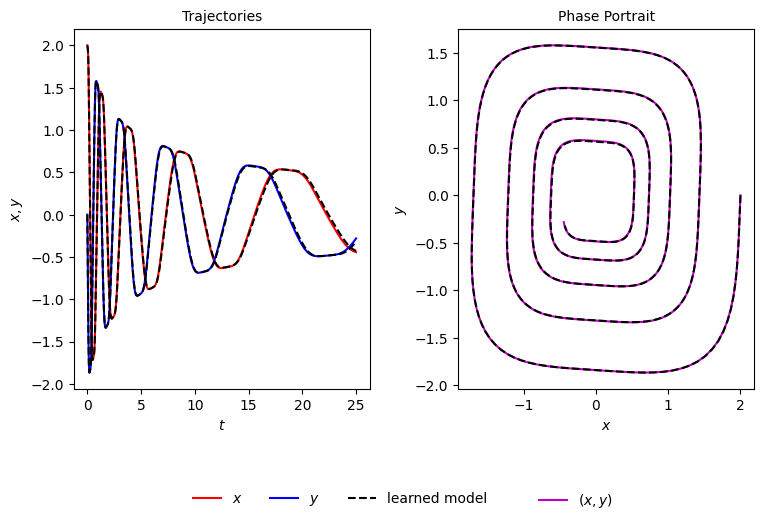

In [ ]:
"""
@author: Maziar Raissi
# """

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

if __name__ == "__main__":

    # function that returns dx/dt
    def f(x,t): # x is 2 x 1
        A = np.array([[-.1,2], [-2,-.1]]) # 2 x 2
        f = np.matmul(A,x[:,None]**3) # 2 x 1
        return f.flatten()

    # time points
    t_star = np.arange(0,25,0.01) #2500 points

    # initial condition
    x0 = np.array([2,0])

    # solve ODE
    X_star = odeint(f, x0, t_star)

    noise = 0.00

    skip = 1
    dt = t_star[skip] - t_star[0] # 0.01
    X_train = X_star[0::skip,:] #(2500, 2)
    X_train = X_train + noise*X_train.std(0)*np.random.randn(X_train.shape[0], X_train.shape[1])

    X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1])) #2500*2: 2500 time, 2 states

    layers = [2, 256, 2]

    M = 1
    scheme = 'AM'
    model = Multistep_NN(dt, X_train, layers, M, scheme)

    N_Iter = 50000
    model.train(N_Iter)


    def learned_f(x,t):
        f = model.predict_f(x[None,:])
        return f.flatten()

    learned_X_star = odeint(learned_f, x0, t_star)
    f_pred = model.sess.run(model.f_pred, feed_dict={model.X_star_tf: X_star})

    ####### Plotting ##################
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=0.85, bottom=0.25, left=0.1, right=0.95, wspace=0.3)

    ax = plt.subplot(gs0[:, 0:1])
    ax.plot(t_star, X_star[:, 0], 'r', label='$x$')
    ax.plot(t_star, X_star[:, 1], 'b', label='$y$')
    ax.plot(t_star, learned_X_star[:, 0], 'k--', label='learned model')
    ax.plot(t_star, learned_X_star[:, 1], 'k--')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x, y$')
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, -0.25), ncol=3, frameon=False)
    ax.set_title('Trajectories', fontsize=10)

    ax = plt.subplot(gs0[:, 1:2])
    ax.plot(X_star[:, 0], X_star[:, 1], 'm', label='$(x,y)$')
    ax.plot(learned_X_star[:, 0], learned_X_star[:, 1], 'k--')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.25), ncol=1, frameon=False)
    ax.set_title('Phase Portrait', fontsize=10)

    # Uncomment the following line to save the figure
    # plt.savefig('./figures/Cubic2D.png')
    plt.show()

In [12]:

def f(x):
    A = np.array([[-.1, 2], [-2, -.1]])  # 2 x 2 matrix
    f_val = np.matmul(A, x[:, None]**3)  # 2 x 1 matrix
    return f_val.flatten()  # flatten to 1D array

# Assuming x_star is already computed and has shape [number of time points, 2]
# Also assuming t_star is defined and corresponds to these time points

# Compute f(x_star) for each time point
f_x_star = np.array([f(X_star[i, :]) for i in range(len(t_star))])


if len(t_star) != f_pred.shape[0]:
    raise ValueError("The length of t_star and the number of rows in f_pred must be the same.")
# Number of state variables
num_states = f_pred.shape[1]

# Plotting each state variable over time
for i in range(num_states):
    plt.figure()
    plt.plot(t_star, f_pred[:, i],'r')
    plt.plot(t_star, f_x_star[:, i], '--k')
    plt.xlabel('Time')
    plt.ylabel(f'State Variable {i+1}')
    plt.title(f'Prediction for State Variable {i+1} Over Time')
    plt.show()

import numpy as np

# Assuming t_star and f_pred are already defined and the following condition is met
if len(t_star) != f_pred.shape[0]:
    raise ValueError("The length of t_star and the number of rows in f_pred must be the same.")

# Stacking t_star, f_pred[:, 1], and f_pred[:, 2] horizontally
data_to_save = np.column_stack((t_star, f_pred[:, 0], f_pred[:, 1], X_star[:, 0], X_star[:, 1]))

# Saving the data to a CSV file
np.savetxt('f_pred_data.csv', data_to_save, delimiter=',', header='t_star,f_pred_1,f_pred_2, X1, X2', comments='')

# Informing that the file has been saved
print("Data saved to 'f_pred_data.csv'.")


ValueError: ignored

In [ ]:
import pandas as pd

# Assuming t_star, f_pred, X_star, and f_x_star are already defined

# Check if the lengths of t_star, f_pred, and X_star match
if len(t_star) != f_pred.shape[0] or len(t_star) != X_star.shape[0]:
    raise ValueError("The lengths of t_star, f_pred, and X_star must all be the same.")

# Create a DataFrame
df = pd.DataFrame({
    "t_star": t_star,
    "f_pred_1": f_pred[:, 0],
    "f_pred_2": f_pred[:, 1],
    "X1": X_star[:, 0],
    "X2": X_star[:, 1]
})

# Save the DataFrame to a CSV file
df.to_csv('combined_data.csv', index=False)

# Informing that the file has been saved
print("Data saved to 'combined_data.csv'.")


Data saved to 'combined_data.csv'.
